In [48]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score,mutual_info_score, f1_score, jaccard_score,precision_score, recall_score, silhouette_score, confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.mixture import GaussianMixture as GMM
from tabulate import tabulate
from pylab import rcParams
from sklearn.decomposition import PCA

import utilsss

plt.rcParams['figure.figsize'] = (17, 5)


In [2]:
# Load metadata and features.
tracks = utilsss.load('tracks.csv')
genres = utilsss.load('genres.csv')
features = utilsss.load('features.csv')
echonest = utilsss.load('echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:
tracks.head(5)

album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []   
5                                           <p></p>    6073      NaN   []   
10                                              NaN   47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>    2710      NaN   []   

          ...       track                         \
          ... information interest language_code   
track_id  ...                                      
2         ...         NaN     4656            en   
3         ...         NaN     1470            en   
5         ...         NaN     1933            en   
10        ...         NaN    54881            en   
20        ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [5]:
def convertTuple(tup):
        # initialize an empty string
    str = ''
    for item in tup:
        str = str + item
    return str

In [ ]:
tracks_copy = tracks.copy()
mask = tracks_copy[('track', 'genres')].apply(lambda x: len(x) > 0)
true_lable = tracks_copy[('track', 'genres')].tolist()
true_lable_clean = [x for x in true_lable if x]

In [6]:
features_columns = []
features_clean = features[mask]
print("features samples:", len(features_clean))
for i in features_clean.columns.tolist():
    features_columns.append(convertTuple(i))

features_clean.columns = features_columns

104343


In [7]:
features_clean.head(5)

chroma_censkurtosis01  chroma_censkurtosis02  chroma_censkurtosis03  \
track_id                                                                        
2                      7.180653               5.230309               0.249321   
3                      1.888963               0.760539               0.345297   
5                      0.527563              -0.077654              -0.279610   
10                     3.702245              -0.291193               2.196742   
20                    -0.193837              -0.198527               0.201546   

          chroma_censkurtosis04  chroma_censkurtosis05  chroma_censkurtosis06  \
track_id                                                                        
2                      1.347620               1.482478               0.531371   
3                      2.295201               1.654031               0.067592   
5                      0.685883               1.937570               0.880839   
10                    -0.234449               1.367364               0.998411   
20                     0.258556               0.775204               0.084794   

          chroma_censkurtosis07  chroma_censkurtosis08  chroma_censkurtosis09  \
track_id                                                                        
2                      1.481593               2.691455               0.866868   
3                      1.366848               1.054094               0.108103   
5                     -0.923192              -0.927232               0.666617   
10                     1.770694               1.604566               0.521217   
20                    -0.289294              -0.816410               0.043851   

          chroma_censkurtosis10  ...  tonnetzstd04  tonnetzstd05  \
track_id                         ...                               
2                      1.341231  ...      0.054125      0.012226   
3                      0.619185  ...      0.063831      0.014212   
5                      1.038546  ...      0.040730      0.012691   
10                     1.982386  ...      0.074358      0.017952   
20                    -0.804761  ...      0.095003      0.022492   

          tonnetzstd06  zcrkurtosis01  zcrmax01  zcrmean01  zcrmedian01  \
track_id                                                                  
2             0.012111       5.758890  0.459473   0.085629     0.071289   
3             0.017740       2.824694  0.466309   0.084578     0.063965   
5             0.014759       6.808415  0.375000   0.053114     0.041504   
10            0.013921      21.434212  0.452148   0.077515     0.071777   
20            0.021355      16.669037  0.469727   0.047225     0.040039   

          zcrmin01  zcrskew01  zcrstd01  
track_id                                 
2         0.000000   2.089872  0.061448  
3         0.000000   1.716724  0.069330  
5         0.000000   2.193303  0.044861  
10        0.000000   3.542325  0.040800  
20        0.000977   3.189831  0.030993  

[5 rows x 518 columns]

In [8]:
echonest_columns = []
echonest_clean = echonest[mask]
for i in echonest_clean.columns.tolist():
    echonest_columns.append(convertTuple(i))

echonest_clean.columns = echonest_columns

/var/folders/qd/438shd_x19l09p0179z9d1p40000gp/T/ipykernel_87754/2874213670.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  echonest_clean = echonest[mask]


In [9]:
echonest_clean.head(5)

echonestaudio_featuresacousticness  \
track_id                                       
2                                   0.416675   
3                                   0.374408   
5                                   0.043567   
10                                  0.951670   
134                                 0.452217   

          echonestaudio_featuresdanceability  echonestaudio_featuresenergy  \
track_id                                                                     
2                                   0.675894                      0.634476   
3                                   0.528643                      0.817461   
5                                   0.745566                      0.701470   
10                                  0.658179                      0.924525   
134                                 0.513238                      0.560410   

          echonestaudio_featuresinstrumentalness  \
track_id                                           
2                                       0.010628   
3                                       0.001851   
5                                       0.000697   
10                                      0.965427   
134                                     0.019443   

          echonestaudio_featuresliveness  echonestaudio_featuresspeechiness  \
track_id                                                                      
2                               0.177647                           0.159310   
3                               0.105880                           0.461818   
5                               0.373143                           0.124595   
10                              0.115474                           0.032985   
134                             0.096567                           0.525519   

          echonestaudio_featurestempo  echonestaudio_featuresvalence  \
track_id                                                               
2                             165.922                       0.576661   
3                             126.957                       0.269240   
5                             100.260                       0.621661   
10                            111.562                       0.963590   
134                           114.290                       0.894072   

         echonestmetadataalbum_date echonestmetadataalbum_name  ...  \
track_id                                                        ...   
2                               NaN                        NaN  ...   
3                               NaN                        NaN  ...   
5                               NaN                        NaN  ...   
10                       2008-03-11          Constant Hitmaker  ...   
134                             NaN                        NaN  ...   

          echonesttemporal_features214 echonesttemporal_features215  \
track_id                                                              
2                            -1.992303                     6.805694   
3                            -1.582331                     8.889308   
5                            -2.288358                    11.527109   
10                           -3.662988                    21.508228   
134                          -1.452696                     2.356398   

          echonesttemporal_features216 echonesttemporal_features217  \
track_id                                                              
2                             0.233070                     0.192880   
3                             0.258464                     0.220905   
5                             0.256821                     0.237820   
10                            0.283352                     0.267070   
134                           0.234686                     0.199550   

         echonesttemporal_features218  echonesttemporal_features219  \
track_id                                                              
2                            0.027455                       0.0640

In [10]:
columns_to_remove = echonest_clean.select_dtypes(include=object).columns.tolist() + echonest_clean.columns[echonest_clean.isna().any()].tolist()
echonest_clean = echonest_clean.drop(columns_to_remove, axis=1)
print("echonest samples:", len(echonest_clean))

13129


In [11]:
echonest_clean.head(5)

echonestaudio_featuresacousticness  \
track_id                                       
2                                   0.416675   
3                                   0.374408   
5                                   0.043567   
10                                  0.951670   
134                                 0.452217   

          echonestaudio_featuresdanceability  echonestaudio_featuresenergy  \
track_id                                                                     
2                                   0.675894                      0.634476   
3                                   0.528643                      0.817461   
5                                   0.745566                      0.701470   
10                                  0.658179                      0.924525   
134                                 0.513238                      0.560410   

          echonestaudio_featuresinstrumentalness  \
track_id                                           
2                                       0.010628   
3                                       0.001851   
5                                       0.000697   
10                                      0.965427   
134                                     0.019443   

          echonestaudio_featuresliveness  echonestaudio_featuresspeechiness  \
track_id                                                                      
2                               0.177647                           0.159310   
3                               0.105880                           0.461818   
5                               0.373143                           0.124595   
10                              0.115474                           0.032985   
134                             0.096567                           0.525519   

          echonestaudio_featurestempo  echonestaudio_featuresvalence  \
track_id                                                               
2                             165.922                       0.576661   
3                             126.957                       0.269240   
5                             100.260                       0.621661   
10                            111.562                       0.963590   
134                           114.290                       0.894072   

          echonestsocial_featuresartist_discovery  \
track_id                                            
2                                        0.388990   
3                                        0.388990   
5                                        0.388990   
10                                       0.557339   
134                                      0.388990   

          echonestsocial_featuresartist_familiarity  ...  \
track_id                                             ...   
2                                          0.386740  ...   
3                                          0.386740  ...   
5                                          0.386740  ...   
10                                         0.614272  ...   
134                                        0.386740  ...   

          echonesttemporal_features214  echonesttemporal_features215  \
track_id                                                               
2                            -1.992303                      6.805694   
3                            -1.582331                      8.889308   
5                            -2.288358                     11.527109   
10                           -3.662988                     21.508228   
134                          -1.452696                      2.356398   

          echonesttemporal_features216  echonesttemporal_features217  \
track_id                                                               
2                             0.233070                      0.192880   
3                             0.258464                      0.220905   
5                             0.256821                      0.237820   
10                            0.283352      

In [12]:
features_clean_all = features_clean.join(echonest_clean)
print("features+echonest num of samples:", len(features_clean_all))
print("features+echonest num of features:",len(features_clean_all.columns))

104343
755


In [13]:
features_clean_all.head(5)

chroma_censkurtosis01  chroma_censkurtosis02  chroma_censkurtosis03  \
track_id                                                                        
2                      7.180653               5.230309               0.249321   
3                      1.888963               0.760539               0.345297   
5                      0.527563              -0.077654              -0.279610   
10                     3.702245              -0.291193               2.196742   
20                    -0.193837              -0.198527               0.201546   

          chroma_censkurtosis04  chroma_censkurtosis05  chroma_censkurtosis06  \
track_id                                                                        
2                      1.347620               1.482478               0.531371   
3                      2.295201               1.654031               0.067592   
5                      0.685883               1.937570               0.880839   
10                    -0.234449               1.367364               0.998411   
20                     0.258556               0.775204               0.084794   

          chroma_censkurtosis07  chroma_censkurtosis08  chroma_censkurtosis09  \
track_id                                                                        
2                      1.481593               2.691455               0.866868   
3                      1.366848               1.054094               0.108103   
5                     -0.923192              -0.927232               0.666617   
10                     1.770694               1.604566               0.521217   
20                    -0.289294              -0.816410               0.043851   

          chroma_censkurtosis10  ...  echonesttemporal_features214  \
track_id                         ...                                 
2                      1.341231  ...                     -1.992303   
3                      0.619185  ...                     -1.582331   
5                      1.038546  ...                     -2.288358   
10                     1.982386  ...                     -3.662988   
20                    -0.804761  ...                           NaN   

          echonesttemporal_features215  echonesttemporal_features216  \
track_id                                                               
2                             6.805694                      0.233070   
3                             8.889308                      0.258464   
5                            11.527109                      0.256821   
10                           21.508228                      0.283352   
20                                 NaN                           NaN   

          echonesttemporal_features217  echonesttemporal_features218  \
track_id                                                               
2                             0.192880                      0.027455   
3                             0.220905                      0.081368   
5                             0.237820                      0.060122   
10                            0.267070                      0.125704   
20                                 NaN                           NaN   

          echonesttemporal_features219  echonesttemporal_features220  \
track_id                                                               
2                              0.06408                       3.67696   
3                              0.06413                       6.08277   
5                              0.06014                       5.92649   
10                             0.08082                       8.41401   
20                                 NaN                           NaN   

          echonesttemporal_features221  echonesttemporal_features222  \
track_id                                                               
2                              3.61288                     13.316690   
3                              6.01864                     16.673548   
5           

In [16]:
print('num of top level generes:')
sorted(list(set(genres['top_level'].tolist())))

[2, 3, 4, 5, 8, 9, 10, 12, 13, 14, 15, 17, 20, 21, 38, 1235]

In [17]:
# replace gener with his top level parent
for idx,t in enumerate(true_lable_clean):
    for i,v in enumerate(t):
        df_temp = genres.filter(items = [v], axis=0)
        true_lable_clean[idx][i]=df_temp['top_level'].values[0]
    true_lable_clean[idx] = list(set(true_lable_clean[idx]))
print("num of true lables after replacement:", len(true_lable_clean)

104343

In [20]:
# fill null value with column median value 
features_clean_all = features_clean_all.fillna(features_clean_all.median())

104343


In [33]:
# External variables

mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(true_lable_clean)
corr_matrix = features_clean_all.corr()

res = pd.DataFrame(y_binary, columns=mlb.classes_)
res_columns = [2, 3, 4, 5, 8, 9, 10, 12, 13, 14, 15, 17, 20, 21, 38, 1235]

features_clean_all_with_lables = features_clean_all.copy()
features_clean_all_with_lables = features_clean_all_with_lables.reset_index()

external_variables_keys = []
external_variables_values = []
for i in res_columns:
    print(f'for top level {i}:')
    temp = features_clean_all_with_lables.join(res[i])
    corr_matrix_features_clean_all = temp.corr()
    # print(corr_matrix_features_clean_all[i].sort_values())
    external_variables_keys.append(corr_matrix_features_clean_all[i].abs().sort_values().nlargest(n=4).keys().tolist()[1:])
    external_variables_values.append(corr_matrix_features_clean_all[i].abs().sort_values().nlargest(n=4).tolist()[1:])
print('External variables keys:\n', external_variables_keys)
print('External variables values:\n', external_variables_values)

for top level 2:
for top level 3:
for top level 4:
for top level 5:
for top level 8:
for top level 9:
for top level 10:
for top level 12:
for top level 13:
for top level 14:
for top level 15:
for top level 17:
for top level 20:
for top level 21:
for top level 38:
for top level 1235:
External variables keys:
 [['mfccmin05', 'mfccstd20', 'mfccmin20'], ['mfccmedian17', 'mfccmean17', 'mfccmean20'], ['mfccmax19', 'chroma_censmax11', 'tonnetzmin04'], ['spectral_contrastmedian04', 'spectral_contrastmean04', 'spectral_contrastmean03'], ['echonesttemporal_features098', 'echonesttemporal_features110', 'echonesttemporal_features134'], ['mfccmean20', 'mfccmedian20', 'tonnetzstd03'], ['tonnetzstd03', 'mfccmax04', 'mfccmedian01'], ['mfccmedian03', 'mfccmean03', 'mfccmedian01'], ['mfccstd04', 'mfccmax04', 'chroma_censstd01'], ['mfccmax04', 'mfccmax06', 'mfccmean04'], ['mfccmedian20', 'mfccmean20', 'mfccmedian16'], ['spectral_contrastmedian02', 'spectral_contrastmean02', 'tonnetzstd03'], ['rmseskew01'

In [224]:
# Table for PDF - 3 top external veriables per cluster

table = [[f'(mfccmin05, {np.round(-0.097399, 3)})', f'(mfccstd20, {np.round(0.092366, 3)})', f'(mfccmin20, {np.round(-0.090961, 3)})'],
         [f'(mfccmedian17, {np.round(-0.080133, 3)})', f'(mfccmean17, {np.round(-0.079730, 3)})', f'(mfccmean20, {np.round(-0.072159, 3)})'],
         [f'(chroma_censmax11, {np.round(0.089196, 3)})', f'(mfccmax19, {np.round(0.089863, 3)})', f'(tonnetzmin04, {np.round(-0.087824, 3)})'],
         [f'(spectral_contrastmedian04, {np.round(0.328990, 3)})', f'(spectral_contrastmean04, {np.round(0.327333, 3)})', f'(spectral_contrastmean03, {np.round(0.302532, 3)})'],
         [f'(echonesttemporal_features098, {np.round(0.395725, 3)})', f'(echonesttemporal_features110, {np.round(0.391606, 3)})', f'(echonesttemporal_features134, {np.round(0.280578, 3)})'],
         [f'(mfccmean20, {np.round(-0.074000, 3)})', f'(mfccmedian20, {np.round(-0.073854, 3)})', f'(tonnetzstd03, {np.round(0.072884, 3)})'],
         [f'(tonnetzstd03, {np.round(0.080089, 3)})', f'(mfccmax04, {np.round(0.076453, 3)})', f'(mfccmedian01, {np.round(0.070104, 3)})'],
         [f'(mfccmedian03, {np.round(-0.298554, 3)})', f'(mfccmean03, {np.round(-0.291543, 3)})', f'(mfccmedian01, {np.round(0.279194, 3)})'],
         [f'(mfccstd04, {np.round(0.030805, 3)})', f'(mfccmax04, {np.round(0.029840, 3)})', f'(chroma_censstd01, {np.round(0.028431, 3)})'],
         [f'(mfccmax04, {np.round(0.064807, 3)})', f'(mfccmax06, {np.round(0.055999, 3)})', f'(mfccmean04, {np.round(0.053655, 3)})'],
         [f'(mfccmedian20, {np.round(0.264915, 3)})', f'(mfccmean20, {np.round(0.258463, 3)})', f'(mfccmedian16, {np.round(0.246339, 3)})'],
         [f'(spectral_contrastmedian02, {np.round(0.224571, 3)})', f'(spectral_contrastmean02, 0.220384)', f'(tonnetzstd03, {np.round(0.205025, 3)})'],
         [f'(rmseskew01, {np.round(0.091535, 3)})', f'(mfccmin10, {np.round(-0.081079, 3)})', f'(mfccmin06, {np.round(-0.077263, 3)})'],
         [f'(rmsestd01, {np.round(0.210326, 3)})', f'(mfccstd06, {np.round(0.196713, 3)})', f'(mfccmax04, {np.round(0.194082, 3)})'],
         [f'(mfccmean01, {np.round(-0.206889, 3)})', f'(mfccmedian01, {np.round(-0.206336, 3)})', f'(spectral_contrastmedian07, {np.round(-0.193408, 3)})'],
         [f'(spectral_contrastmean03, {np.round(0.232765, 3)})', f'(spectral_contrastmedian03, {np.round(0.232609, 3)})', f'(spectral_contrastmean04, {np.round(0.225851, 3)})']]
     
index_names = [f"top lebel {top_level}" for top_level in res_columns]

print(tabulate(table, headers=["Feature 1st", "Feature 2nd", "Feature 3rd"], showindex=index_names, tablefmt="latex"))

\begin{tabular}{llll}
\hline
                & Feature 1st                           & Feature 2nd                           & Feature 3rd                           \\
\hline
 top lebel 2    & (mfccmin05, -0.097)                   & (mfccstd20, 0.092)                    & (mfccmin20, -0.091)                   \\
 top lebel 3    & (mfccmedian17, -0.08)                 & (mfccmean17, -0.08)                   & (mfccmean20, -0.072)                  \\
 top lebel 4    & (chroma\_censmax11, 0.089)             & (mfccmax19, 0.09)                     & (tonnetzmin04, -0.088)                \\
 top lebel 5    & (spectral\_contrastmedian04, 0.329)    & (spectral\_contrastmean04, 0.327)      & (spectral\_contrastmean03, 0.303)      \\
 top lebel 8    & (echonesttemporal\_features098, 0.396) & (echonesttemporal\_features110, 0.392) & (echonesttemporal\_features134, 0.281) \\
 top lebel 9    & (mfccmean20, -0.074)                  & (mfccmedian20, -0.074)                & (tonnetzstd03, 0.073)    

In [141]:
def plot_results(X, ground_truth_binary, predicted):
    # #plotting the results:
    pca = PCA(2)
    X = pca.fit_transform(X)


    data = pd.DataFrame(data = X, columns = ['x','y'])    
    data['true'] = [np.where(predicted_binary[i]==1)[0][0] if x[np.where(predicted_binary[i]==1)[0][0]]==1 else np.where(x == 1)[0][0] for i,x in enumerate(ground_truth_binary)]
    data['pred'] = predicted


    # define a custom color palette with 16 different colors
    my_palette = ['#FF0000', '#FFA500', '#FFFF00', '#008000', '#00FFFF', '#0000FF', '#800080', '#FFC0CB', '#FF69B4', '#00FF00', '#FF7F50', '#000000', '#800000', '#FFD700', '#808080', '#8B4513']

    # set the custom color palette
    sns.set_palette(my_palette)

    with sns.axes_style("darkgrid"):

        # Create a scatterplot with large points for the ground truth labels
        sns.scatterplot(x="x", y="y", hue="true", data=data, s=250, palette=my_palette[0:len(set(data['true']))], alpha=0.5)

        # Overlay a scatterplot with smaller points for the predicted labels
        sns.scatterplot(x="x", y="y", hue="pred", data=data, s=10, palette=my_palette[0:len(set(data['pred']))], alpha=1)


    # Add a legend with modified labels
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [f'{i}' for i in range(max(len(set(data['true'])), len(set(data['pred']))))]
    plt.legend(handles, labels)

    rcParams['figure.figsize'] = 30, 15

    # Show the plot
    plt.show()
    
def resultsPerModel(X, y, model, Visualization = False, anomaly = False, external_variables_keys_ = None):
    
    mlb = MultiLabelBinarizer()
    y_binary = mlb.fit_transform(y)

    if anomaly:
        data = X.copy()
        data.insert(loc=0, column='ganeres', value=y)    
        temp = data.copy()
        for i in data.columns.tolist()[1:]:
            mean = data[i].mean()
            std = data[i].std()
            # calculate upper threshold
            threshold_1 = mean + 3*std
            threshold_2 = mean - 3*std
            # select rows where feature is less than or equal to threshold
            data = data[(data[i] >= threshold_2) & (data[i] <= threshold_1)]
        
        df_only_anomaly = temp.drop(index = data.index.values.tolist())
        
        external_variables_values_all = []
        for i in range(len(external_variables_keys_)):
            if 'ganeres' not in external_variables_keys_[i]:
                external_variables_keys_[i].append('ganeres')
            if 'track_id' in external_variables_keys_[i]:
                external_variables_keys_[i].remove('track_id')
            df_only_anomaly_ = df_only_anomaly[external_variables_keys_[i][0:4]]
            mlb = MultiLabelBinarizer()
            y_binary = mlb.fit_transform(df_only_anomaly_['ganeres'])

            res = pd.DataFrame(y_binary, columns=mlb.classes_)
            res_columns = [2, 3, 4, 5, 8, 9, 10, 12, 13, 14, 15, 17, 20, 21, 38, 1235]

            features_clean_all_with_lables = df_only_anomaly_.copy()
            features_clean_all_with_lables = features_clean_all_with_lables.drop(columns=['ganeres'])
            features_clean_all_with_lables = features_clean_all_with_lables.reset_index()
            
            if np.sum(res[res_columns[i]])>0:
                temp = features_clean_all_with_lables.join(res[res_columns[i]])
                corr_matrix_features_clean_all = temp.corr()
                external_variables_values_all.append(corr_matrix_features_clean_all[res_columns[i]].abs().sort_values().nlargest(n=4).tolist()[1:4])
                print(f'External variables values_top_level{res_columns[i]}:\n', corr_matrix_features_clean_all[res_columns[i]].abs().sort_values().nlargest(n=4).tolist()[1:4])
            
        y = data['ganeres']
        mlb = MultiLabelBinarizer()
        y_binary = mlb.fit_transform(y)
        X = data.drop(columns=['ganeres'])

    if hasattr(model, "fit_predict"):
        pred = model.fit_predict(X)
    else:
        pred = model.fit(X).predict(X)
    
    pred_binary = np.zeros_like(y_binary)
    pred_binary[np.arange(len(pred)), pred] = 1
    
    my_list = y_binary.sum(axis=0)
    sorted_indices = sorted(range(len(my_list)), key=lambda i: my_list[i])
    pred_binary = np.take(pred_binary, sorted_indices, axis=1)

    # Metrics
    print('Metrics scores:')
    accuracy = accuracy_score(y_binary,pred_binary)
    precision = precision_score(y_binary, pred_binary, average='macro')
    silhouette = silhouette_score(X, pred)
    silhouette_norm = (silhouette+1) / 2
    F1_score = f1_score(y_binary , pred_binary, average='macro')
    print("Accuracy:", accuracy)
    print("Precision:",precision)
    print("Silhouette_score:", silhouette_norm)
    print("F1 score:", F1_score)
    metrics_average = np.average([accuracy,precision,silhouette_norm,F1_score])
    print("Metrics average:", metrics_average)        

    if Visualization:
        print('\nVisualization:')
        plot_results(X, y_binary, pred)

    if anomaly:   
        return accuracy, precision, silhouette, F1_score, metrics_average, external_variables_values_all
    else:
        return accuracy, precision, silhouette, F1_score, metrics_average

Metrics scores:
Accuracy: 0.03242191618029001
Precision: 0.11637006797124969
Silhouette_score: 0.5875732582730027
F1 score: 0.046838224089676694
Metrics average: 0.19580086662855478

Visualization:


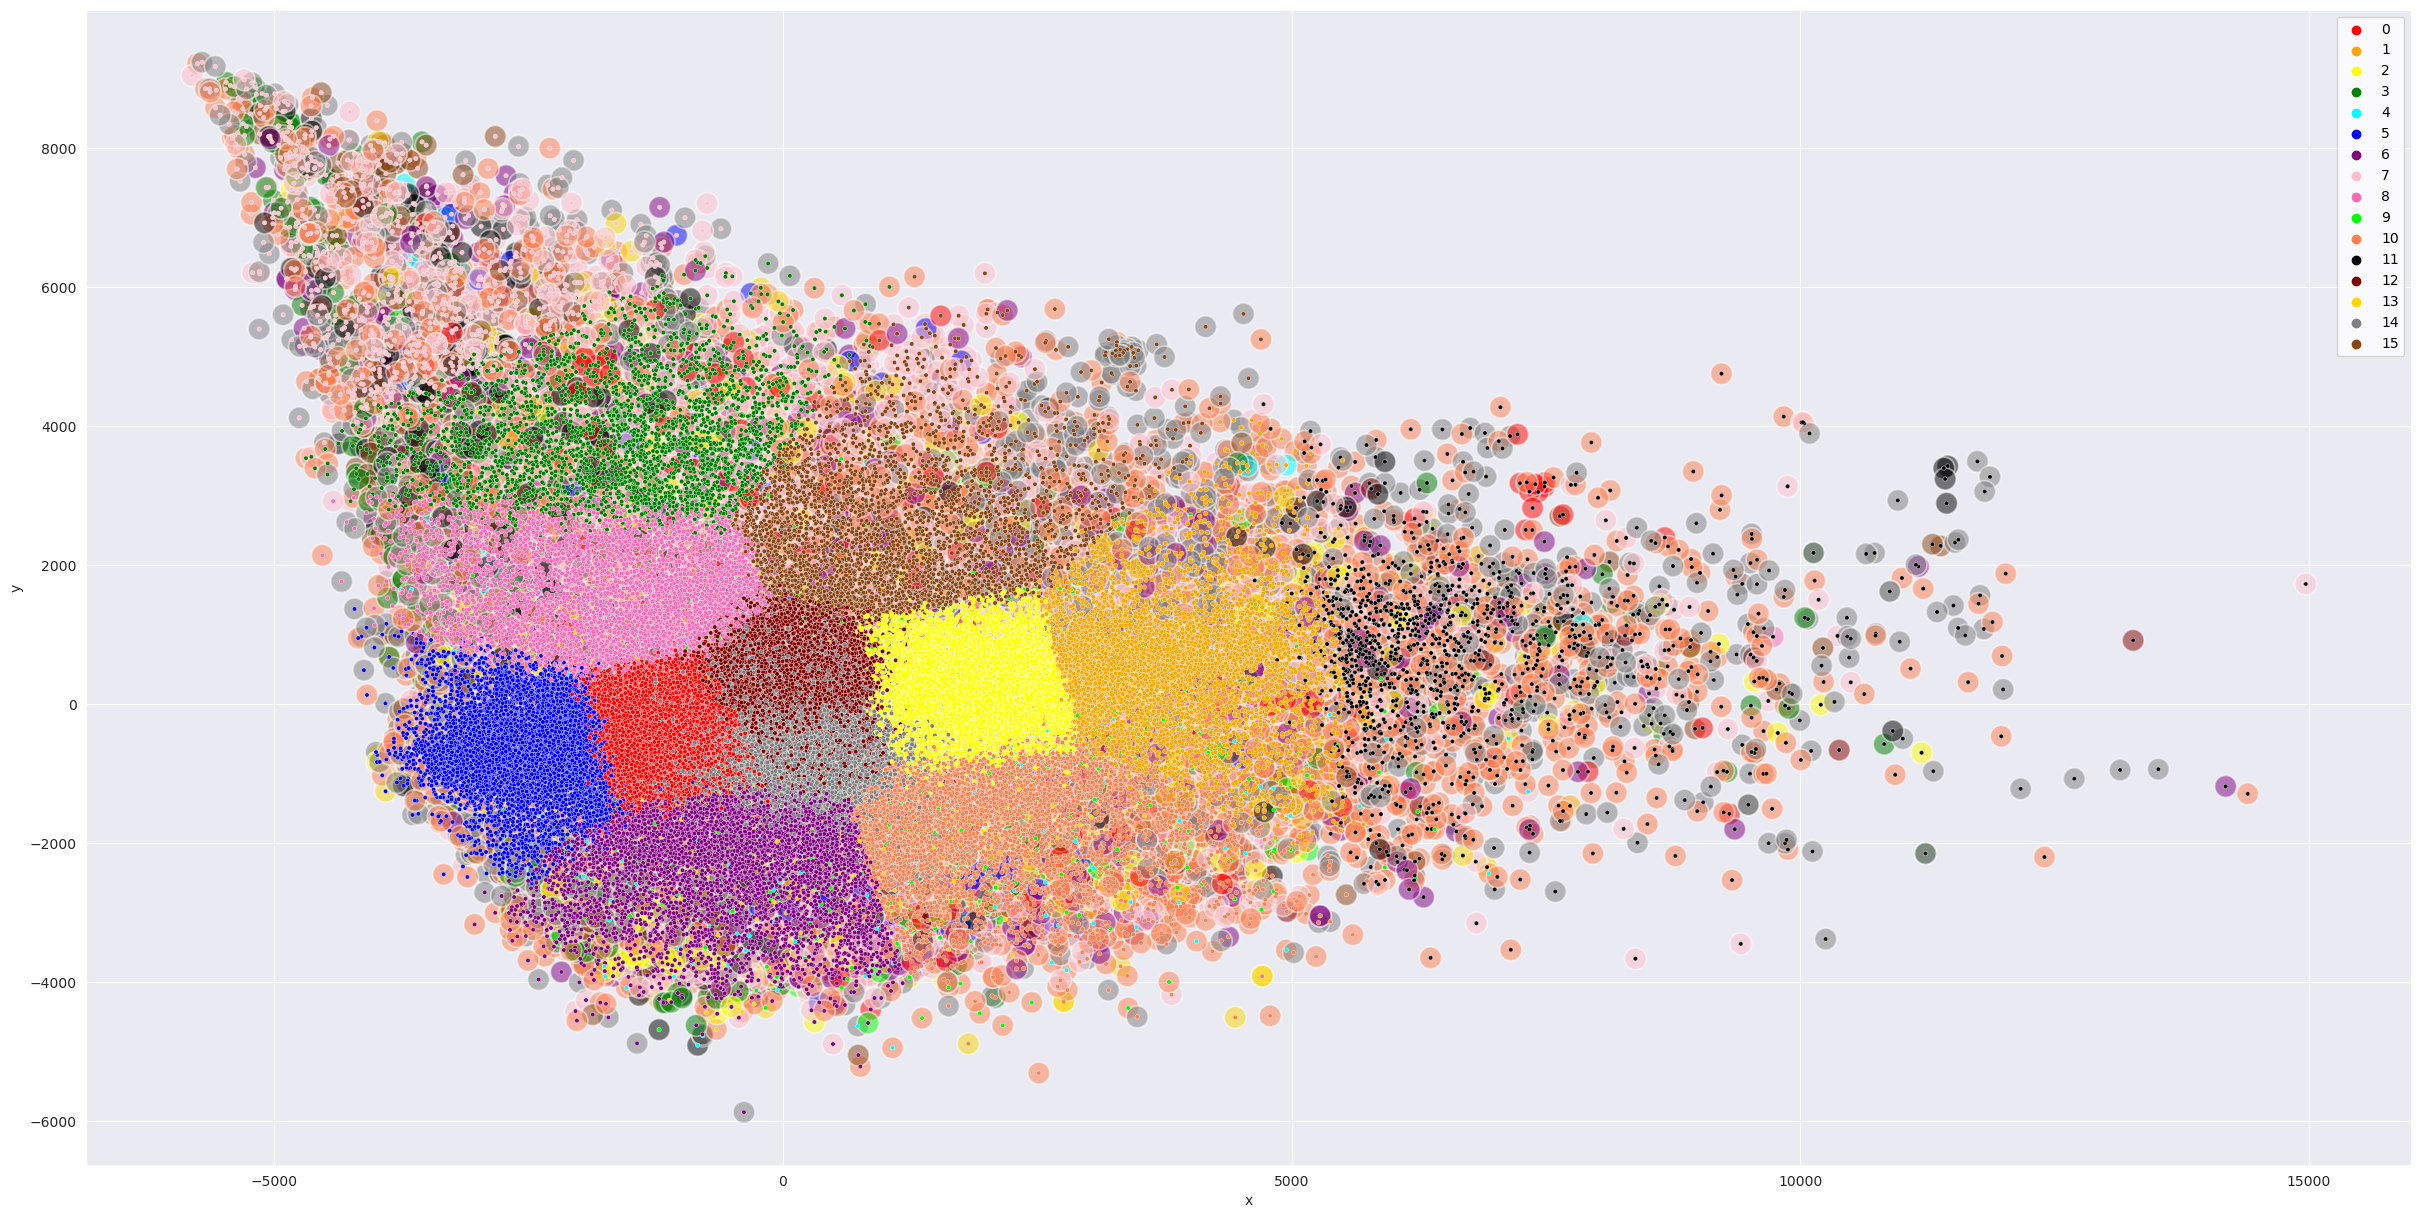

In [58]:
# kmeans
kmeans = KMeans(n_clusters=16, random_state=0)
X = features_clean_all
y = true_lable_clean
accuracy_kmeans, precision_kmeans, silhouette_kmeans ,F1_score_kmeans , metrics_average_kmeans = resultsPerModel(X, y, kmeans, Visualization = True)


Metrics scores:
Accuracy: 0.015372377639132476
Precision: 0.10562177737469816
Silhouette_score: 0.575354798513814
F1 score: 0.03655864585787892
Metrics average: 0.18322689984638088

Visualization:


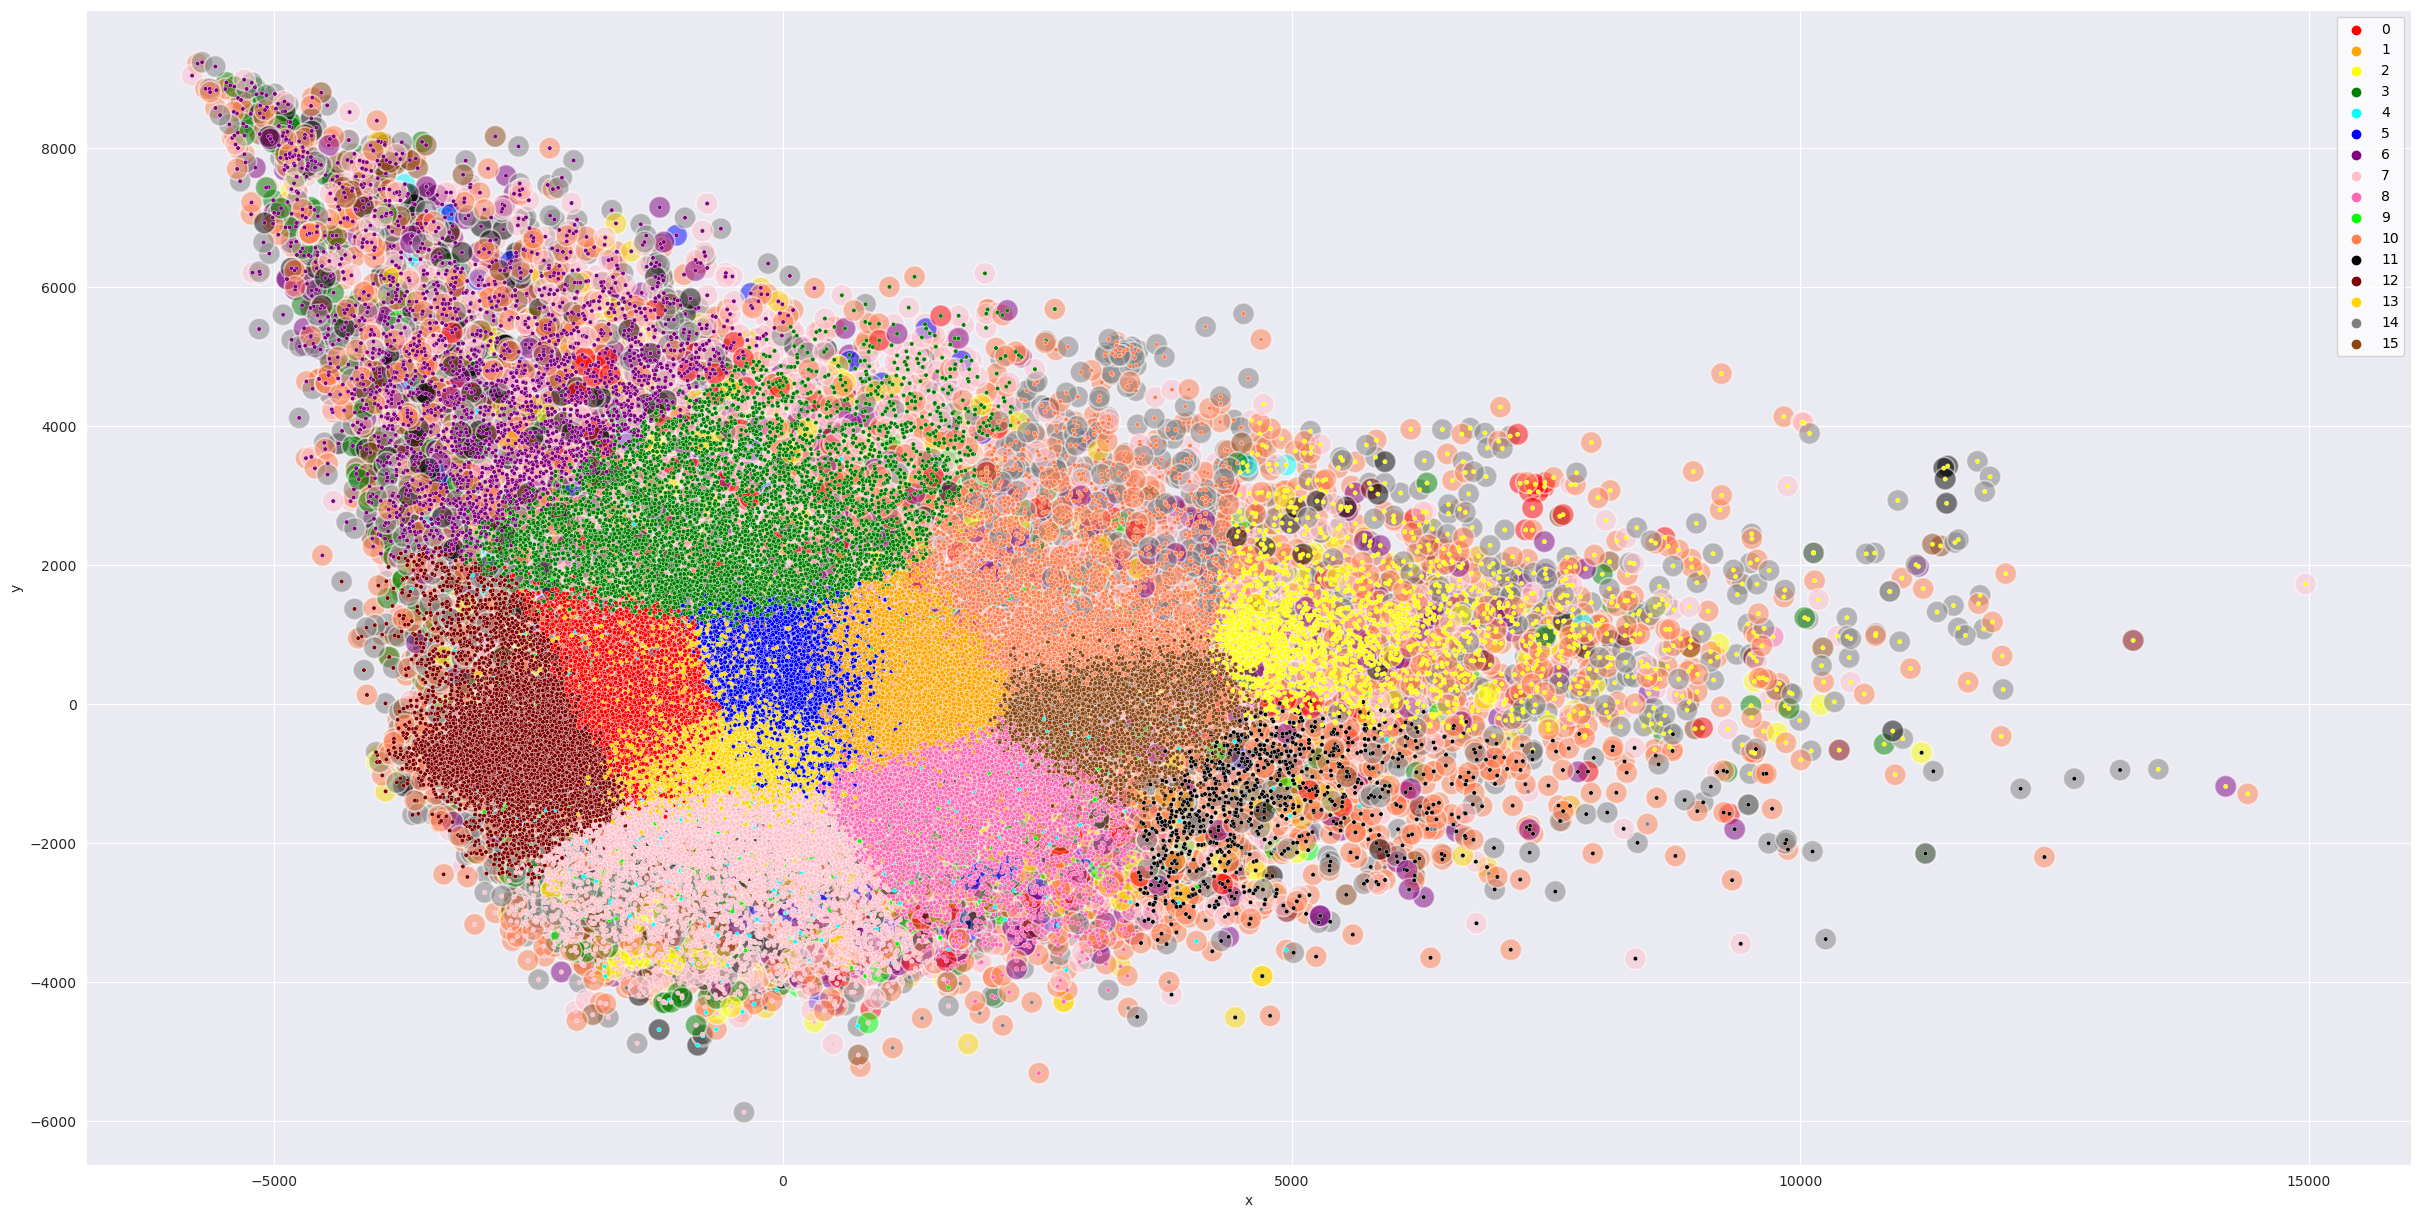

In [124]:
# MiniBatchKMeans
miniBatchKmeans = MiniBatchKMeans(n_clusters=16, random_state=0)
X = features_clean_all
y = true_lable_clean
accuracy_miniBatchKmeans, precision_miniBatchKmeans, silhouette_miniBatchKmeans ,F1_score_miniBatchKmeans , metrics_average_miniBatchKmeans = resultsPerModel(X, y, miniBatchKmeans, Visualization = True)

External variables values_top_level2:
 [0.09671613050945124, 0.09339937555104223, 0.09071973745749486]
External variables values_top_level3:
 [0.0810375079606807, 0.08061360976010899, 0.07238544616866374]
External variables values_top_level4:
 [0.08806602710665137, 0.08581591700748428, 0.08526987034027253]
External variables values_top_level5:
 [0.33041784457575146, 0.3287113481421494, 0.3038676075920581]
External variables values_top_level8:
 [0.3959512124024704, 0.3918344118195238, 0.2807550293524094]
External variables values_top_level9:
 [0.07440170194835975, 0.07425690581653906, 0.07323027017108777]
External variables values_top_level10:
 [0.07984865121867818, 0.07450563288760145, 0.06866482220275306]
External variables values_top_level12:
 [0.2990057359666564, 0.2920485567618413, 0.28103922331698267]
External variables values_top_level13:
 [0.03104444963577745, 0.030340805861950874, 0.028808390226264]
External variables values_top_level14:
 [0.06348540501885966, 0.055238349257986

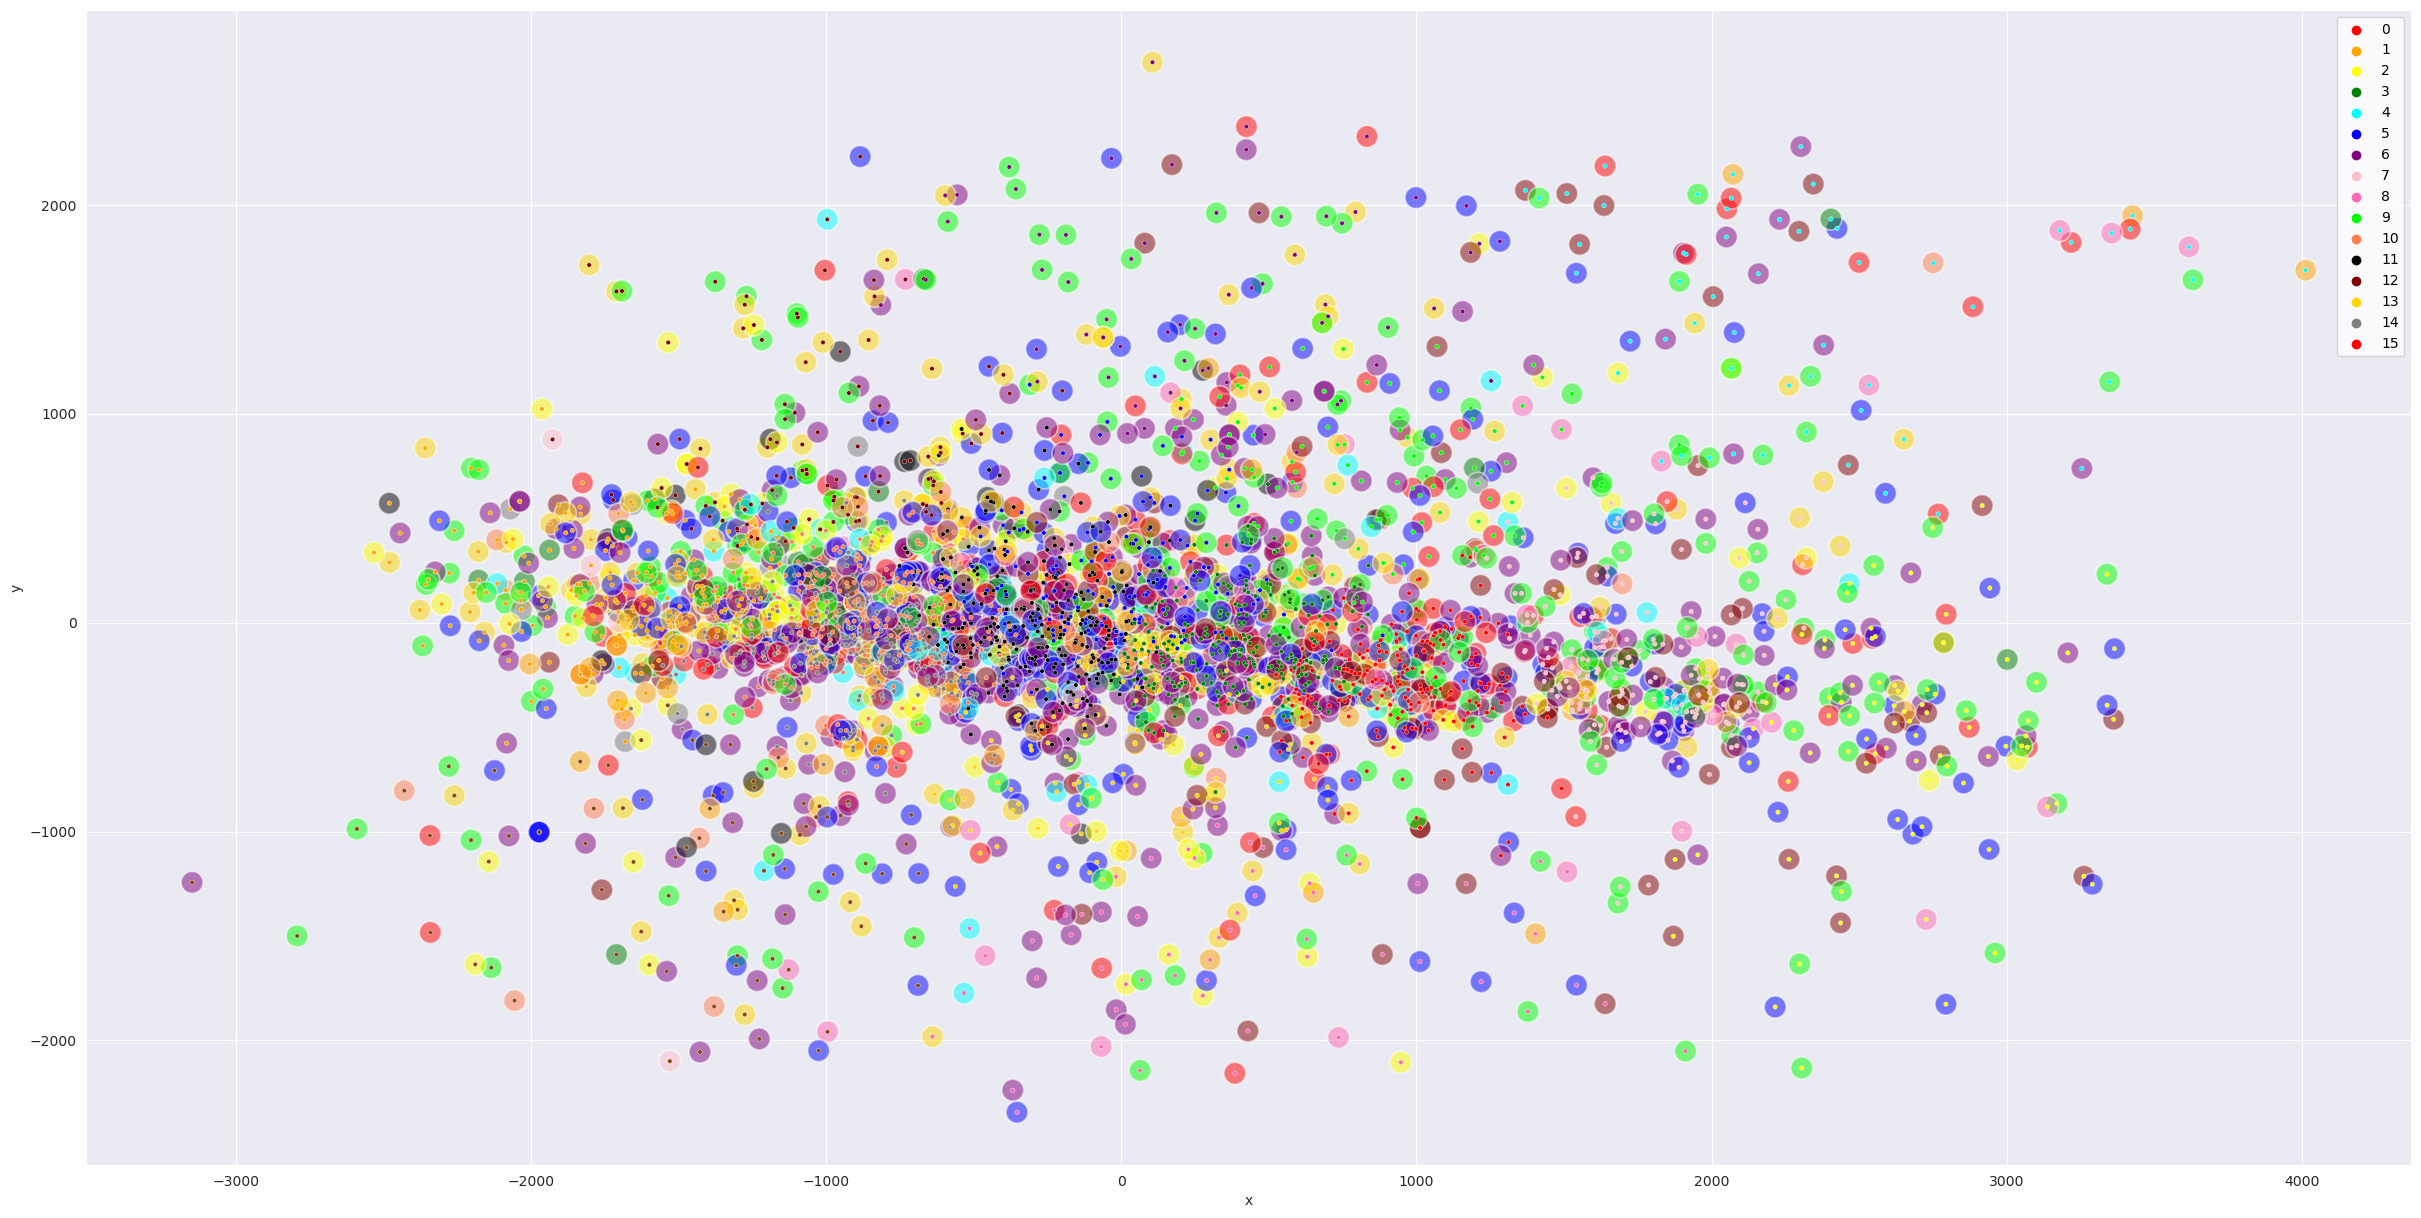

In [143]:
# kmeans - after anomaly
kmeans = KMeans(n_clusters=16, random_state=0)
X = features_clean_all
y = true_lable_clean
external_variables_keys_ = external_variables_keys.copy()
accuracy_kmeans_after_anomaly, precision_kmeans_after_anomaly, silhouette_kmeans_after_anomaly ,F1_score_kmeans_after_anomaly , metrics_average_kmeans_after_anomaly, external_variables_values_after_anomaly = resultsPerModel(X, y, miniBatchKmeans, True, True, external_variables_keys_)

In [32]:
# Table for PDF - find best clusterign algorithm by average metrics

table = [[0.032, 0.0154],
         [0.116, 0.106],
         [0.588, 0.575],
         [0.047, 0.037],
         [0.196, 0.183]]
        
index_names = ["Average Accuracy", "Average Precision", "Average Silhouette", "Average F1", "Average Metrics"]

print(tabulate(table, headers=["Kmeans", "MiniBatchKMeans"], showindex=index_names, tablefmt="latex"))

\begin{tabular}{lrr}
\hline
                    &   Kmeans &   MiniBatchKMeans \\
\hline
 Average Accuracy   &    0.032 &            0.0154 \\
 Average Precision  &    0.116 &            0.106  \\
 Average Silhouette &    0.588 &            0.575  \\
 Average F1         &    0.047 &            0.037  \\
 Average Metrics    &    0.196 &            0.183  \\
\hline
\end{tabular}
